# Report project

This project was done in the scope of the CS-439 : Optimization for ML course. Moreover, the project was done by :  
- Brioschi Riccardo 
- Mossinelli Giacomo
- Havolli Albias 

### Import useful libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from cnn_architectures import *

### Load data and reshape it 

In [3]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
#load data
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)



#reshape it 
mnist_train_set = mnist_trainset.data.view(-1, 1, 28, 28).float()
mnist_test_set = mnist_testset.data.view(-1, 1, 28, 28).float()
mnist_train_target = mnist_trainset.targets
mnist_test_target = mnist_testset.targets

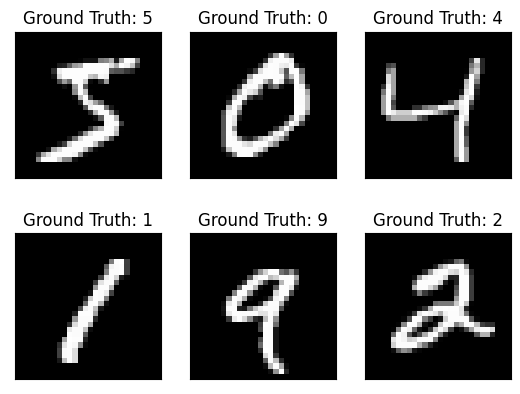

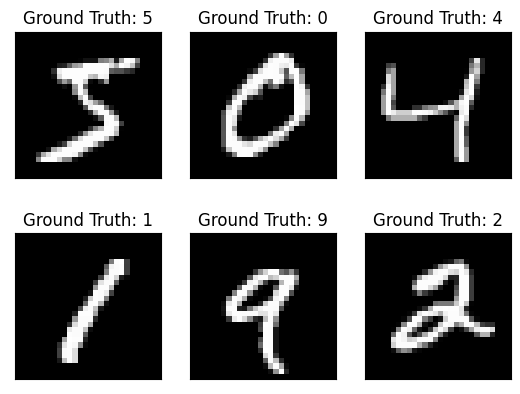

In [21]:
#plotting some training examples
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  #plt.tight_layout()
  plt.imshow(mnist_train_set[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(mnist_train_target[i]))
  plt.xticks([])
  plt.yticks([])
fig